In [4]:
!pip show matplotlib


Name: matplotlib
Version: 3.3.4
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: c:\users\mahmu\appdata\roaming\python\python36\site-packages
Requires: cycler, pyparsing, numpy, python-dateutil, pillow, kiwisolver
Required-by: seaborn, scikit-image


## Import Necessary Packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#For plotting line segments
from matplotlib.collections import LineCollection

#Interactive backend
%matplotlib nbagg

## Class Joint

In [6]:
class Joint:
    '''
    parent   : Reference to Rope object
    id       : Index in parent's list of Joints
    held     : Boolean for interactivity
    x        : Current horizontal position
    y        : Current vertical position
    px       : Previous horizontal position
    py       : Previous vertical position
    bounce   : Percentage velocity retained upon collision with boundary
    fixed    : Boolean for update rules. Fixed points don't move.
    '''
    def __init__(self, x, y, fixed = False, bounce = 0.4):
        self.parent = None #Specified when list of Joints are assigned to Rope
        self.id     = None #Specified when list of Joints are assigned to Rope

        self.held   = False #True if dragged
        self.fixed  = fixed
        self.bounce = bounce # How much velocity is kept after wall collision


        #Initialize position with 0 speed.
        #Note that Verlet integration does not have a velocity attribute!
        #See the naming conventions from docstring above.
        #Your code here

        self.x = x
        self.y = y
        # As initial speed is 0, previous and current pos is same
        self.px = x
        self.py = y
        
    @property
    #Get position of Joint
    def pos(self):
        return (self.x, self.y)


    #Update according to Verlet integration
    #with added gravitational acceleration
    def update(self):
        dt = self.parent.dt
        g = self.parent.g
        
        # acceleration in x and y 
        gx, gy = 0, -g
        
        temp_x = self.px
        self.x += (self.x - self.px) + gx * dt * dt
        self.px = temp_x
        
        temp_y = self.py
        self.y += (self.y - self.py) + gy * dt * dt
        self.py = temp_y
        

    #If joint has crossed the bounds of the box, set it back to the bound
    #and reflect its velocity, scaled by the bounce factor.
    def check_boundary(self):
        vx = (self.x-self.px)*self.bounce
        vy = (self.y-self.py)*self.bounce

        box_size = self.parent.box_size

        #Boundary check code
        #Hint: How can you keep the speed but reverse the direction
        # when bouncing, without a velocity term?
        
        if self.x > box_size:
            #temp = self.x
            self.px = box_size + vx
            self.x = box_size
            
        elif self.x < -box_size:
            #temp = self.x
            self.px = -box_size + vx
            self.x = -box_size
            
        elif self.y > box_size:
            #temp = self.y
            self.py = box_size + vy
            self.y = box_size
            
        elif self.y < -box_size:
            #temp = self.y
            self.py = -box_size + vy
            self.y = -box_size
        
        


## Class Rope

In [7]:
class Rope:
    '''
    joints   : List of Joint objects. Are connected to their neighbours
    seglen   : Target length of each segment
    g        : Gravitational acceleration
    dt       : Time step size
    box_size : Sets xlim and ylim of plot
    stiffness: Amount of iterations the constrain loop makes
    '''
    def __init__(self, joints, segmentlen, step_size, stiffness = 4, gravity = 9.81, box_size = 100):
        for i, joint in enumerate(joints):
            joint.parent = self
            joint.id     = i

        self.joints = joints
        self.seglen = segmentlen
        self.g = gravity
        self.dt = step_size
        self.box_size = box_size
        self.stiffness = stiffness

    @property
    #Get true length of rope
    #Should return a float
    def length(self):
        return self.seglen * len(self.joints)

    @property
    #Get list of joint positions, [(x1,y1), (x2,y2), ...]
    def pos(self):
        return np.transpose([(j.x,j.y) for j in self.joints])

    @property
    #Get indices of fixed joints
    def f_i(self):
        return np.transpose([j.id for j in self.joints if j.fixed])

    @property
    #Get segment length errors for colormapping
    #Should return a list of errors
    def errors(self):
        dist_x = np.array([self.joints[i+1].x - self.joints[i].y for i in range(len(self.joints)-1)])
        dist_y = np.array([self.joints[i+1].y - self.joints[i].y for i in range(len(self.joints)-1)])
        current_len = np.sqrt(dist_x**2 + dist_y**2)
        errors = current_len - self.seglen
        return errors

    @property
    #Get segments in the form [[(x1,y1),(x2,y2)], [(x2,y2),(x3,y3)], ...]
    def segments(self):
        return [[self.joints[i].pos,self.joints[i+1].pos] for i in range(len(self.joints)-1)]


    #Takes indices to joints and returns their Euclidean distance
    def dist(self, i1, i2):
        j1 = self.joints[i1]
        j2 = self.joints[i2]
        return np.linalg.norm([j1.x-j2.x,j1.y-j2.y])

    def constrain(self, i1, i2):
        #Your code goes here - make sure that the segments are not too long
        #See the optional reading if confused: <https://youtu.be/FcnvwtyxLds?t=516>

        #Error ratio compared to target distance
        restDist = self.seglen * abs((i2-i1))
        
        dx = self.joints[i1].x - self.joints[i2].x
        dy = self.joints[i1].y - self.joints[i2].y
        currentDist = np.sqrt(dx**2 + dy**2)
        
        if currentDist != restDist:
            s = (restDist - currentDist) / currentDist
        else: s = 0
        
        #If both points are fixed, don't change them
        if self.joints[i1].fixed and self.joints[i2].fixed:
            pass

        #If one is fixed, move the other to the correct distance
        elif self.joints[i1].fixed:
            self.joints[i2].x -= dx*s
            self.joints[i2].y -= dy*s
            
        elif self.joints[i2].fixed:
            self.joints[i1].x += dx*s
            self.joints[i1].y += dy*s

        #If neither is fixed, move both equally to correct distance
        else:
            self.joints[i1].x += dx*0.5*s
            self.joints[i1].y += dy*0.5*s
            
            self.joints[i2].x -= dx*0.5*s
            self.joints[i2].y -= dy*0.5*s


    def update(self):
        #Update with Verlet integration
        for j in self.joints:
            j.update()
        #Apply constraint pass a number of times
        for _ in range(self.stiffness):
            for i in range(len(self.joints)-1):
                self.constrain(i,i+1)
        #Resolve collisions with boundary of plot.
        for j in self.joints:
            j.check_boundary()


In [8]:
# Extra cell as needed
class Joint:
    '''
    parent   : Reference to Rope object
    id       : Index in parent's list of Joints
    held     : Boolean for interactivity
    x        : Current horizontal position
    y        : Current vertical position
    px       : Previous horizontal position
    py       : Previous vertical position
    bounce   : Percentage velocity retained upon collision with boundary
    fixed    : Boolean for update rules. Fixed points don't move.
    '''
    def __init__(self, x, y, fixed = False, bounce = 0.4):
        self.parent = None #Specified when list of Joints are assigned to Rope
        self.id     = None #Specified when list of Joints are assigned to Rope
        
        self.held   = False #True if dragged
        self.fixed = fixed
        
        #Initialize position with 0 speed.
        self.x = x
        self.px = x
        self.y = y
        self.py = y
        
        self.bounce = bounce #How much velocity is kept after wall collision
        
    @property
    #Get position of Goint
    def pos(self):
        return (self.x, self.y)
    
    
    #Update according to Verlet integration
    #with added gravitational acceleration
    def update(self):
        if not self.fixed:
            vx = self.x-self.px
            vy = self.y-self.py

            self.px, self.py = self.x, self.y
            self.x += vx
            self.y += vy - self.parent.g * self.parent.dt
        
    #If joint has crossed the bounds of the box, set it back to the bound
    #and reflect its velocity, scaled by the bounce factor.
    def check_boundary(self):
        vx = (self.x-self.px)*self.bounce
        vy = (self.y-self.py)*self.bounce
        
        box_size = self.parent.box_size
    
        # right boundary    
        if self.x > box_size:
            self.x = box_size
            self.px = box_size + vx
            self.py = self.y-vy
            # self.y - (self.y - self.py)*bounce
            # self.py = self.py * bounce
        
        # left boundary
        elif self.x < -box_size:
            self.x = -box_size
            self.px = -box_size + vx
            self.py = self.y-vy
            
        # top 
        if self.y > box_size:
            self.y  = box_size
            self.py = box_size + vy
            self.px = self.x-vx
        #bottom
        elif self.y < -box_size:
            self.y = -box_size
            self.py = -box_size + vy
            self.px = self.x-vx

class Rope:
    '''
    joints   : List of Joint objects. Are connected to their neighbours
    seglen   : Target length of each segment
    g        : Gravitational acceleration
    dt       : Time step size
    box_size : Sets xlim and ylim of plot
    stiffness: Amount of iterations the constrain loop makes
    '''
    def __init__(self, joints, segmentlen, step_size, stiffness = 4, gravity = 9.81, box_size = 100):
        for i, joint in enumerate(joints):
            joint.parent = self
            joint.id     = i
        
        self.joints = joints
        self.seglen = segmentlen
        self.g = gravity
        self.dt = step_size
        self.box_size = box_size
        self.stiffness = stiffness
    
    @property
    #Get true length of rope
    def length(self):
        return sum([self.dist(i,i+1) for i in range(len(self.joints)-1)])
    
    @property
    #Get list of joint positions, [(x1,y1), (x2,y2), ...]
    def pos(self):
        return np.transpose([(j.x,j.y) for j in self.joints])

    @property
    #Get indices of fixed joints
    def f_i(self):
        return np.transpose([j.id for j in self.joints if j.fixed])
    
    @property
    #Get segment length errors for colormapping
    def errors(self):
        return [self.dist(i,i+1)-self.seglen for i in range(len(self.joints)-1)]
    
    @property
    #Get segments in the form [[(x1,y1),(x2,y2)], [(x2,y2),(x3,y3)], ...]
    def segments(self):
        return [[self.joints[i].pos,self.joints[i+1].pos] for i in range(len(self.joints)-1)]
        
    
    #Takes indices to joints and returns their Euclidean distance
    def dist(self, i1, i2):
        j1 = self.joints[i1]
        j2 = self.joints[i2]
        return np.linalg.norm([j1.x-j2.x,j1.y-j2.y])
    
    def constrain(self, i1, i2):
        #Useful distances and differences
        dist = self.dist(i1,i2)
        diff = dist-self.seglen
        difx = self.joints[i1].x-self.joints[i2].x
        dify = self.joints[i1].y-self.joints[i2].y
        
        #Error ratio compared to target distance
        scale = 0
        if dist > 0:
            scale = self.seglen/dist
        
        #If both points are fixed, don't change them
        if self.joints[i1].fixed and self.joints[i2].fixed:
            pass
        
        #If one is fixed, move the other to the correct distance
        elif self.joints[i1].fixed:
            self.joints[i2].x = self.joints[i1].x - difx*scale
            self.joints[i2].y = self.joints[i1].y - dify*scale
        elif self.joints[i2].fixed:
            self.joints[i1].x = self.joints[i2].x + difx*scale
            self.joints[i1].y = self.joints[i2].y + dify*scale
            
        #If neither is fixed, move both equally to correct distance
        else:
            avgx = (self.joints[i1].x+self.joints[i2].x)/2
            avgy = (self.joints[i1].y+self.joints[i2].y)/2
            
            self.joints[i1].x = avgx + difx*scale/2
            self.joints[i1].y = avgy + dify*scale/2
            self.joints[i2].x = avgx - difx*scale/2
            self.joints[i2].y = avgy - dify*scale/2
            

    def update(self):
        #Update with Verlet integration
        for j in self.joints:
            j.update()
        #Apply constraint pass a number of times
        for _ in range(self.stiffness):
            for i in range(len(self.joints)-1):
                self.constrain(i,i+1)
        #Resolve collisions with boundary of plot.
        for j in self.joints:
            j.check_boundary()

#When mouse is clicked on plot        
def onclick(event):
    global mp, target
    
    #Mouse was clicked
    mp = True
    
    #Log click location
    e_pos = np.asarray([event.xdata, event.ydata])
    target = None
    
    #If clicked near fixed joint, pick it up
    idxs = rope.f_i
    for i in idxs:
        j = rope.joints[i]
        if np.linalg.norm(np.subtract(e_pos, j.pos)) < rope.box_size/10:
            target = j.id
            break
    
    #If we didn't click near a fixed joint, what is the closest joint?
    if target == None:
        distances = [np.linalg.norm(np.subtract(e_pos, j.pos)) for j in rope.joints]
        min_i = np.argmin(distances)
        
        #If closest joint is near, pick it up
        if distances[min_i] < rope.box_size/10:
            target = min_i
    
    #If we're holding a joint...
    if target != None:
        #...let it know that it's being held...
        if rope.joints[target].fixed:
            #Fixed points don't need a change in attributes
            pass
        else:
            #Non-fixed points are made fixed while held
            rope.joints[target].held = True
            rope.joints[target].fixed = True
        
        #... and move it to the cursor
        rope.joints[target].x = e_pos[0]
        rope.joints[target].y = e_pos[1]

## Event Handling

In [9]:
#When mouse is moved over plot
def onmove(event):
    global mp, target
    #If the mouse is pressed
    if mp:
        #Position of event on the plot
        e_pos = np.asarray([event.xdata, event.ydata])

        #If cursor not moved beyond plot
        if event.xdata != None and event.ydata != None:
            #Update held object's position
            rope.joints[target].x = e_pos[0]
            rope.joints[target].y = e_pos[1]

        #If moving beyond plot
        else:
            #Drop held object
            offclick(event)

#When mouse is clicked on plot
def onclick(event):
    global mp, target

    # Mouse was clicked
    mp = True

    # Log click location
    e_pos = np.asarray([event.xdata, event.ydata])
    target = None #When a target joint is found, set this to Joint.id

    #If clicked near fixed joint, pick it up
    idxs = rope.f_i
    for i in idxs:
        j = rope.joints[i]

        # Find the distance to the joint, and decide if it is close enough
        # A good threshold is rope.box_size/10
        dist = np.sqrt((e_pos[0]-j.x)**2 + (e_pos[1]-j.y)**2)
        if dist < rope.box_size/10:
            target = j.id
            break

    #If we didn't click near a fixed joint, what is the closest joint?
    #Find the closest joint!
    #Your code here
    
    if target == None:
        min_dist = rope.box_size
        closest_joint = None
        for j in rope.joints:
            if not j.fixed:
                dist = np.sqrt((e_pos[0]-j.x)**2 + (e_pos[1]-j.y)**2)
                if dist < min_dist:
                    min_dist = dist
                    closest_joint = j.id
        target = closest_joint
                
    

    #If we're holding a joint...
    if target != None:
        #...let it know that it's being held...
        if rope.joints[target].fixed:
            #Fixed points don't need a change in attributes
            pass
        else:
            #Non-fixed points are made fixed while held
            rope.joints[target].held = True
            rope.joints[target].fixed = True

        #... and move it to the cursor
        #Jatin, if you don't like stretchy rope, you can insert a constraint
        #relative to the neighbours of the held joints here.
        rope.joints[target].x = e_pos[0]
        rope.joints[target].y = e_pos[1]

#When mouse is released or moved off plot
def offclick(event):
    global mp, target
    #Mouse was released
    mp = False

    #If the held object was initially non-fixed, make it non-fixed again
    if rope.joints[target].held:
        rope.joints[target].held = False
        rope.joints[target].fixed = False

    #Drop held object
    target = None


## Animation Loop

In [10]:
#Animation loop to be called each frame
def animate(i):
    rope.update() #Update the rope's position
    line.set_segments(rope.segments) #Update position plot of rope
    line.set_color(colormap(rope.errors)) #Update colors of segments
    title.set_text(f'Rope len: ({rope.length:.2f})') #Update title

    #Return artist, i.e. our plot object
    return line,


## Call Script

<IPython.core.display.Javascript object>


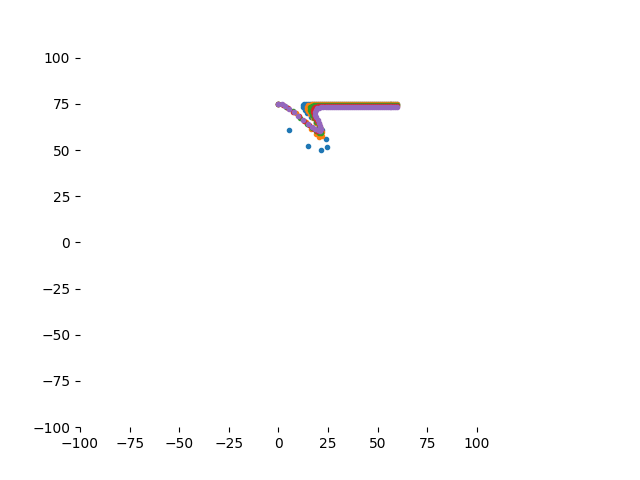

In [11]:
colormap = plt.get_cmap('coolwarm') #Colormap for errors
mp = False #Mouse pressed
target = None #Joint to hold

#Set rope parameters
segmentlen = 1 #Target lenght of segments
stiff = 4 #Stiffness
g = 9.81 #Gravitational acceleration

####Sample ropes:####

#Loose rope, try picking it up after it has fallen!
#joints = [Joint(segmentlen*i,75-0.5*i) for i in range(31)]

#Rope hanging from one end
joints = [Joint(0,75, fixed = True), *[Joint(segmentlen*i,75) for i in range(1,61)]]

#Suspended rope between two points
#joints = [Joint(0,75, fixed = True),
#          *[Joint(np.sqrt(segmentlen)*i,75-np.sqrt(segmentlen)*i) for i in range(1,60)],
#          Joint(np.sqrt(segmentlen)*60,75-np.sqrt(segmentlen)*60, fixed = True)]

#####################

#Set animation parameters
frame_r = 80
step_size = 1/frame_r

#Create rope
rope = Rope(joints, segmentlen, step_size, stiffness = stiff, gravity = g)

#Create figure
fig, ax = plt.subplots()
title = ax.set_title(f'Rope len: ({rope.length:.2f})')

ax.set_xlim(-rope.box_size, rope.box_size)
ax.set_ylim(-rope.box_size, rope.box_size)

#Plot rope as segments, colored on the coolwarm cmap according to rope.errors
lc = LineCollection(rope.segments, cmap = colormap)
lc.set_array(rope.errors)
lc.set_clim([-segmentlen,segmentlen])
line = ax.add_artist(lc) #This is the actual 'artist' object we will update

#Add colorbar to plot
cbar = fig.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Error in segment length', rotation=270)

#Create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=1, interval=10000/frame_r, blit=True)

#Connect event listeners for moving and pressing/releasing mouse
fig.canvas.mpl_connect('motion_notify_event', onmove)
fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('button_release_event', offclick)

#Show interactive simulation to user
plt.show()


## Testing for Debugging

In [12]:
for i in range(5):
    rope.update()
    x = [j.x for j in rope.joints]
    y = [j.y for j in rope.joints]
    plt.plot(x,y, '.', label = str(i))
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


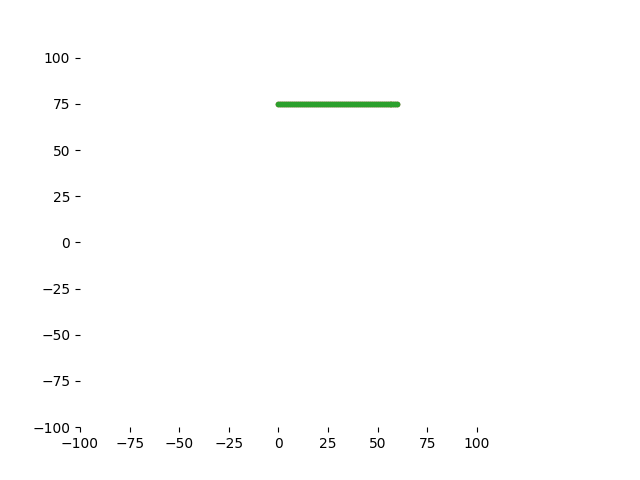

In [13]:
#Rope hanging from one end
joints = [Joint(0,75, fixed = True), *[Joint(segmentlen*i,75) for i in range(1,61)]]

#Create rope
rope = Rope(joints, segmentlen, step_size, stiffness = stiff, gravity = g)

#rope.update()

#Create figure
fig, ax = plt.subplots()
title = ax.set_title(f'Rope len: ({rope.length:.2f})')

ax.set_xlim(-rope.box_size, rope.box_size)
ax.set_ylim(-rope.box_size, rope.box_size)

#Plot rope as segments, colored on the coolwarm cmap according to rope.errors
lc = LineCollection(rope.segments, cmap = colormap)
lc.set_array(rope.errors)
lc.set_clim([-segmentlen,segmentlen])
line = ax.add_artist(lc) #This is the actual 'artist' object we will update

#Add colorbar to plot
cbar = fig.colorbar(lc)
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('Error in segment length', rotation=270)

plt.show()

In [14]:
for i in range(3):
    x = [j.x for j in rope.joints]
    y = [j.y for j in rope.joints]
    plt.plot(x,y, '.', label = str(i-1))
    plt.legend()
    plt.show()
    rope.update()

In [15]:
[j.x for j in rope.joints]

[0,
 0.8830662970277563,
 1.8979411879370172,
 2.922807401073358,
 3.9430807579206077,
 4.958779836738676,
 5.970597780048919,
 6.979298703862228,
 7.985589921769886,
 8.990070461889758,
 9.993220301781491,
 10.995409616775266,
 11.996915958037718,
 12.997942910923253,
 13.998637171743407,
 14.99910287799632,
 15.99941300985424,
 16.999618135407687,
 17.9997529388044,
 18.999840990604692,
 19.99989817330853,
 20.999935105056807,
 21.999958832591698,
 22.999974000391134,
 23.99998364981583,
 24.99998976027569,
 25.999993612562506,
 26.99999603085451,
 27.999997542717885,
 28.99999848416062,
 29.999999068160463,
 30.999999429092398,
 31.999999651364348,
 32.999999787772666,
 33.99999987120629,
 34.99999992207262,
 35.99999995298633,
 36.99999997171658,
 37.99999998303137,
 38.999999989846856,
 39.99999999394068,
 40.999999996393,
 41.99999999785812,
 42.999999998731184,
 43.999999999250136,
 44.99999999955784,
 45.99999999973986,
 46.99999999984729,
 47.99999999991054,
 48.99999999994770

## Pre-class Work Questions